# Uniform Distribution

## Setup

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
sns.set_theme()

In [3]:
df = pd.read_csv("../../data/uniform.csv", comment='#', converters={"rates": lambda x: np.fromstring(x[1:-1], dtype=int, sep=' ')})

## Prepare `DataFrame`

add statistics to `df`

In [4]:
df['n'] = df['rates'].apply(len)

In [5]:
df['h'] = df['rates'].apply(np.sum)

In [6]:
df['cycle-end'] = df['cycle-start'] + df['cycle-length']

In [7]:
df['norm_backlog'] = df['backlog'] / df['h']

In [8]:
df['norm_rates'] = df['rates'] / df['h']

In [9]:
df['std'] = df['norm_rates'].apply(np.std)

In [10]:
df['min'] = df['norm_rates'].apply(np.min)

In [11]:
df['max'] = df['norm_rates'].apply(np.max)

In [12]:
df['nunique'] = df['norm_rates'].apply(lambda x: len(np.unique(x)))

In [13]:
df['norm_rates_str'] = df['norm_rates'].astype("string")

In [14]:
df['diff-backlog'] = df.groupby(by='norm_rates_str', group_keys=False)['norm_backlog'].apply(lambda x: x - x.min())

In [15]:
df['diff-cycle-start'] = df.groupby(by='norm_rates_str', group_keys=False)['cycle-start'].apply(lambda x: x - x.min())

In [16]:
df['diff-cycle-length'] = df.groupby(by='norm_rates_str', group_keys=False)['cycle-length'].apply(lambda x: x - x.min())

In [17]:
df['best-backlog'] = df['diff-backlog'] == 0

## Distribution of Backlog

histogram of backlog for every strategy, bins start at 1, width 0.05

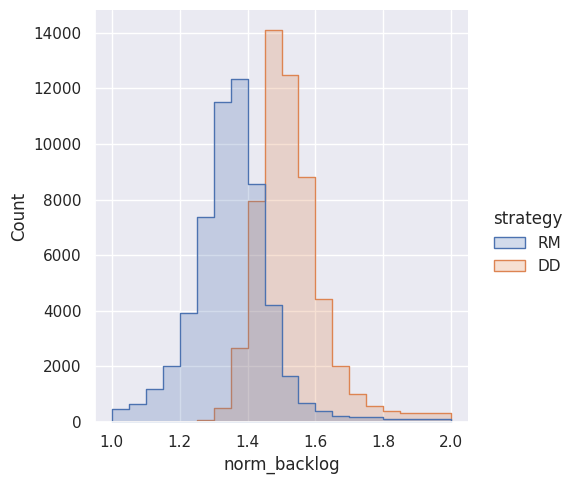

In [18]:
bins = np.arange(21) / 20 + 1
sns.displot(data=df, x='norm_backlog', hue='strategy', element='step', bins=bins)

eCDF of backlog for every strategy

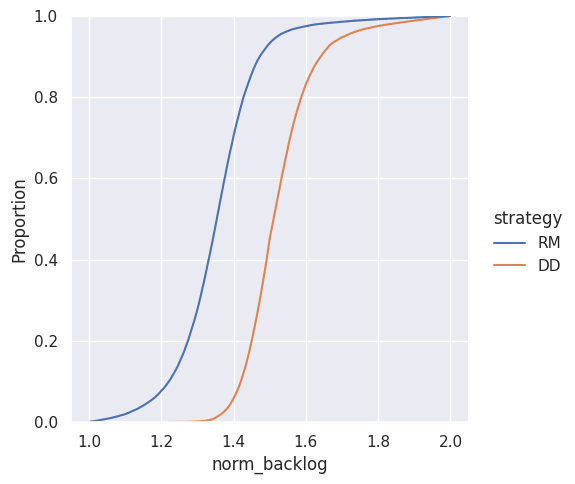

In [19]:
sns.displot(data=df, x='norm_backlog', hue='strategy', kind='ecdf')

mean backlog for every strategy

In [20]:
df.groupby('strategy')['norm_backlog'].mean()

strategy
DD    1.525679
RM    1.353618
Name: norm_backlog, dtype: float64

percentage of instances where `Reduce-Max` is not the best strategy

In [21]:
len(df[(df['strategy'] == 'RM') & (df['diff-backlog'] != 0)]) / len(df[df['strategy'] == 'RM'])

0.0645

eCDF of the difference between a strategy's backlog compared to the smallest backlog for this instance (`diff-backlog`)

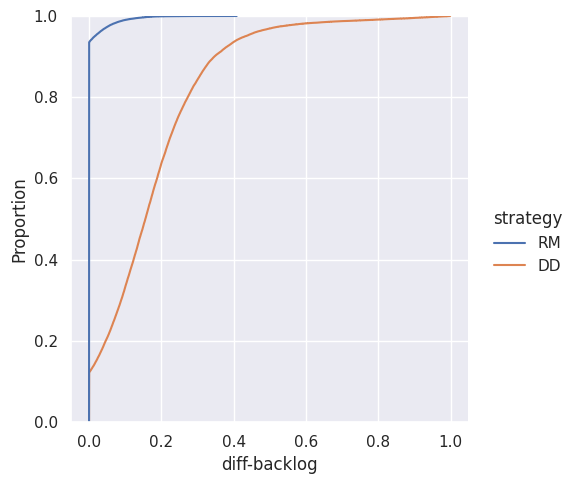

In [22]:
sns.displot(data=df, x='diff-backlog', hue='strategy', kind='ecdf')

violin plot showing the kernel density estimation (KDE) for each strategy's backlog, split by `best-backlog`

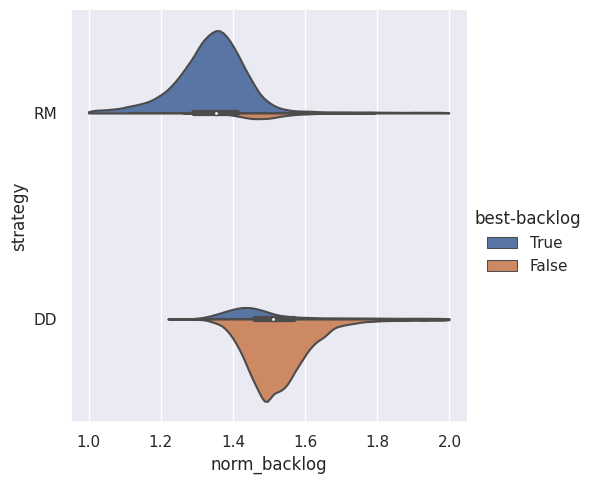

In [23]:
sns.catplot(data=df, x='norm_backlog', y='strategy', hue='best-backlog', hue_order=[True, False], kind='violin', split=True, cut=0, scale='count')

## Backlog by number of cups

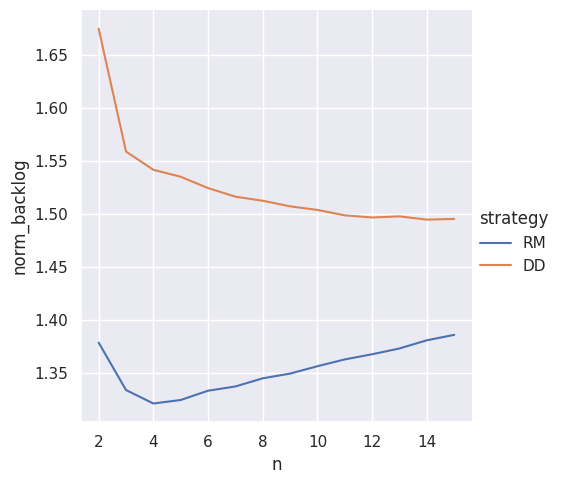

In [24]:
sns.relplot(data=df.groupby(['n', 'strategy'], sort=False).agg({'norm_backlog': 'mean'}), x='n', y='norm_backlog', hue='strategy', kind='line')

letter-value plot showing backlog categorized by the number of cups

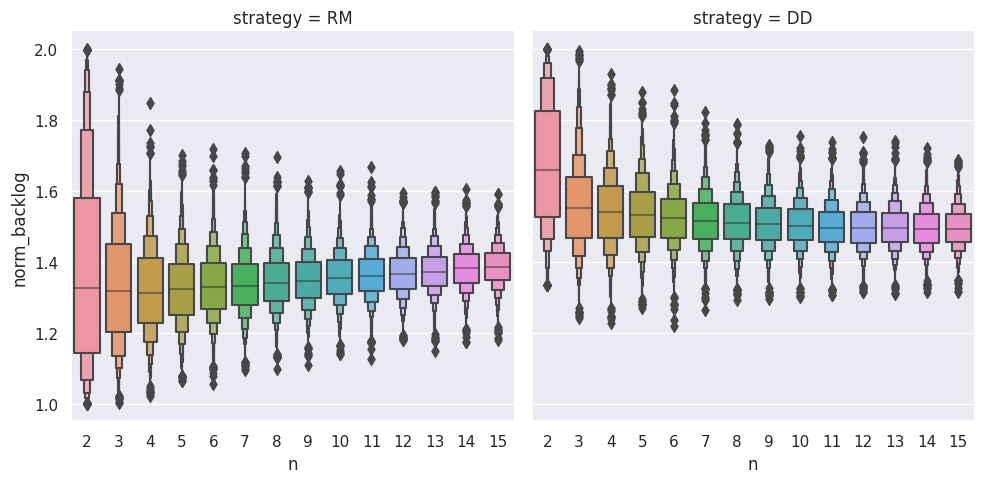

In [25]:
sns.catplot(data=df, x='n', y='norm_backlog', col='strategy', kind='boxen')

number of instances categorized by number of duplicate fill rates (`//2` is necessary since every instance appears twice in `df`, once for every strategy)

In [26]:
(df['n'] - df['nunique']).value_counts()//2

0    53870
1     2072
2       55
3        3
dtype: int64

letter-value plot showing backlog categorized by the number of unique fill rates present in an instance

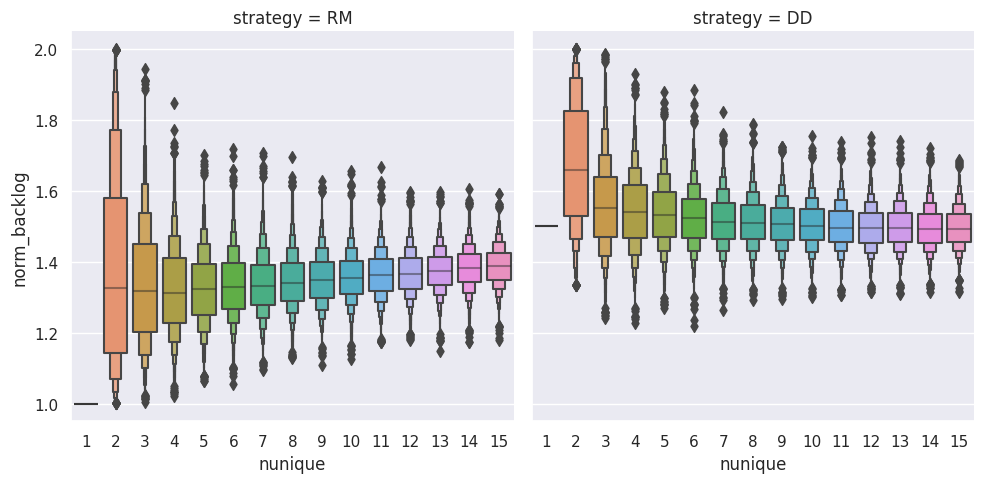

In [27]:
sns.catplot(data=df, x='nunique', y='norm_backlog', col='strategy', kind='boxen')

## Correlation of min and max fill rates

scatter plot of backlog by min and max fill rates

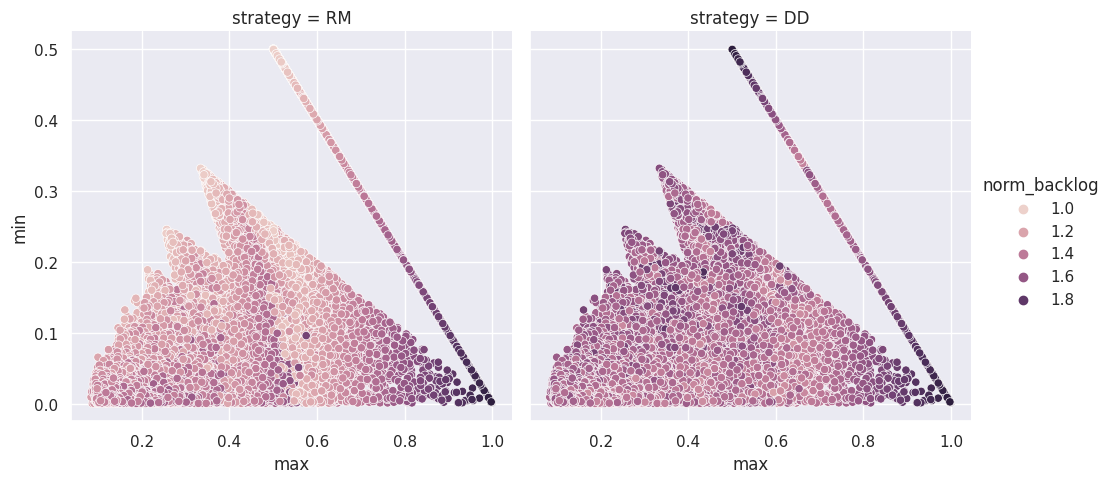

In [28]:
sns.relplot(df, x='max', y='min', hue='norm_backlog', col='strategy')

pivot table for heatmaps (rounded fill rates to reduce number of tiles)

In [29]:
pt_max = df.round({'max': 2}).pivot_table(index=['strategy', 'max'], columns='nunique', values='norm_backlog', aggfunc=np.max).iloc[::-1]
pt_mean = df.round({'max': 2}).pivot_table(index=['strategy', 'max'], columns='nunique', values='norm_backlog', aggfunc=np.mean).iloc[::-1]

common colorbar values for heatmaps

In [30]:
vmin = min(np.nanmin(pt_max.values), np.nanmin(pt_mean.values))
vmax = max(np.nanmax(pt_max.values), np.nanmax(pt_mean.values))

heatmap showing max backlog for RM, depending on max fill rate and number of unique fill rates

<AxesSubplot: xlabel='nunique', ylabel='max'>

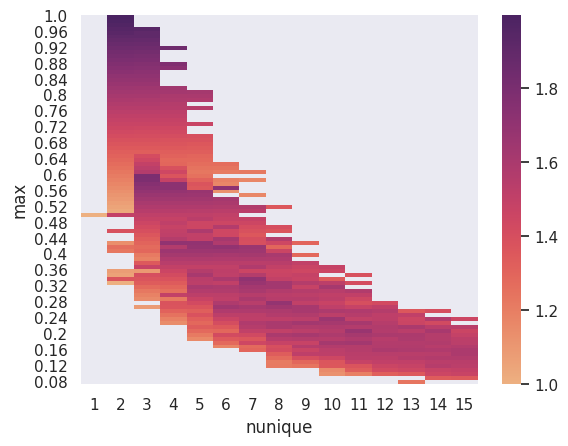

In [31]:
sns.heatmap(pt_max.loc['RM'], cmap='flare', vmin=vmin, vmax=vmax)

heatmap showing max backlog for DD, depending on max fill rate and number of unique fill rates

<AxesSubplot: xlabel='nunique', ylabel='max'>

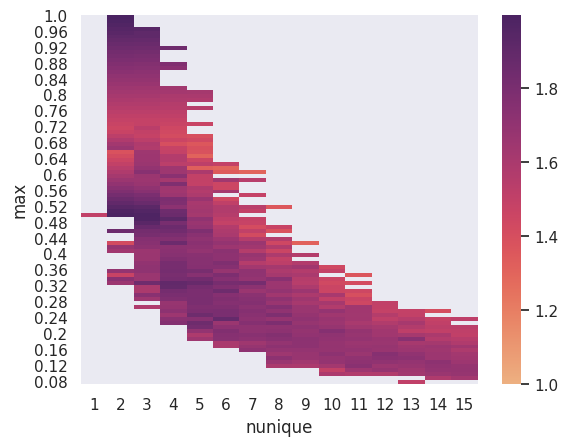

In [32]:
sns.heatmap(pt_max.loc['DD'], cmap='flare', vmin=vmin, vmax=vmax)

heatmap showing mean backlog for RM, depending on max fill rate and number of unique fill rates

<AxesSubplot: xlabel='nunique', ylabel='max'>

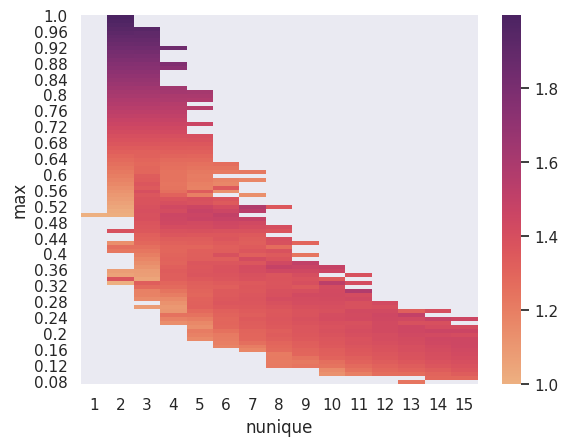

In [33]:
sns.heatmap(pt_mean.loc['RM'], cmap='flare', vmin=vmin, vmax=vmax)

heatmap showing mean backlog for DD, depending on max fill rate and number of unique fill rates

<AxesSubplot: xlabel='nunique', ylabel='max'>

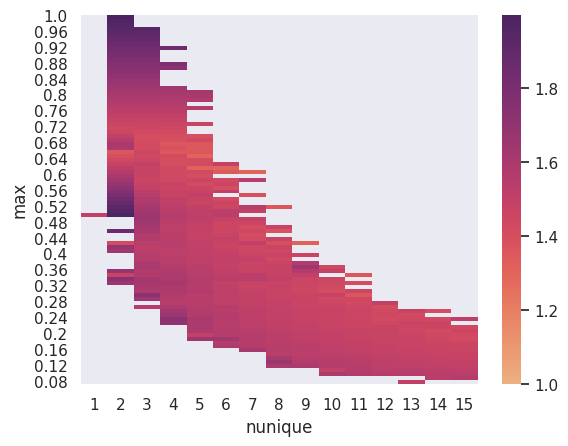

In [34]:
sns.heatmap(pt_mean.loc['DD'], cmap='flare', vmin=vmin, vmax=vmax)

letter-value plot comparing backlog between rounded min fill rates

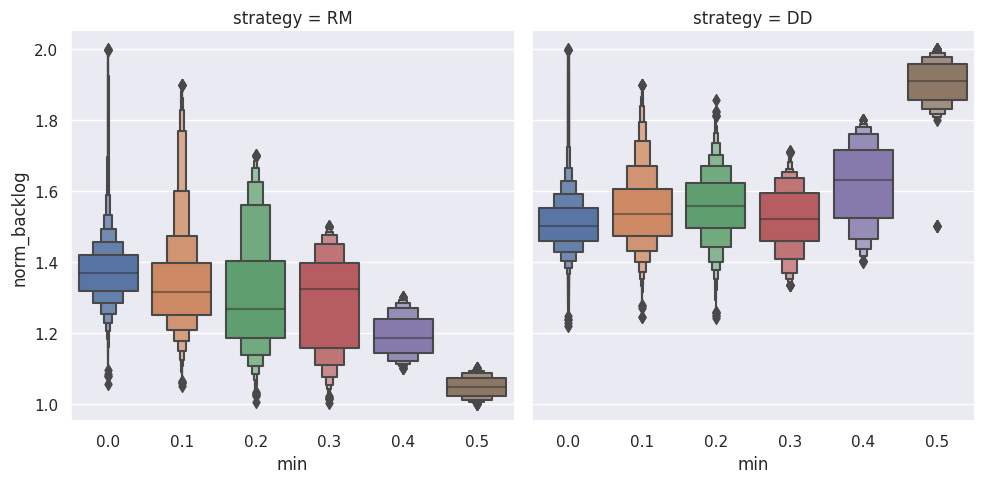

In [35]:
sns.catplot(df.round({'min': 1}), x='min', y='norm_backlog', col='strategy', kind='boxen')

letter-value plot comparing backlog between rounded max fill rates

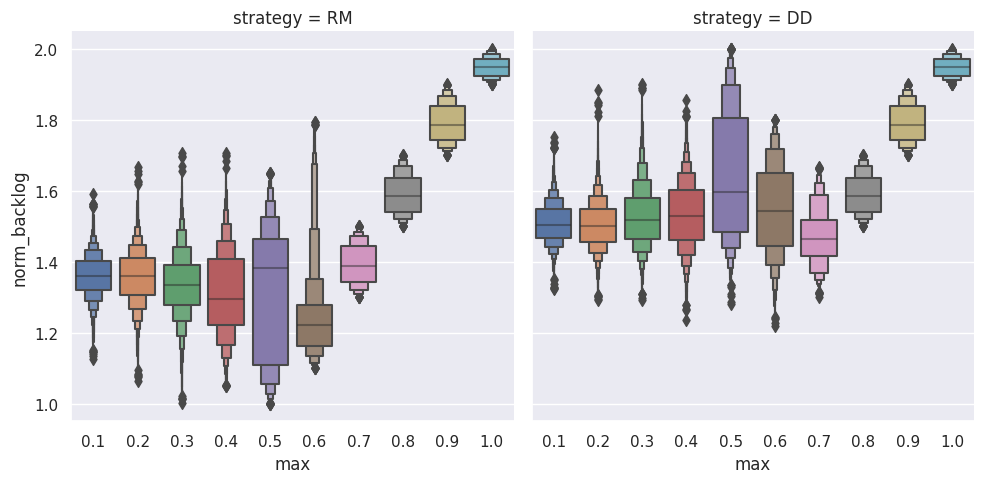

In [36]:
sns.catplot(df.round({'max': 1}), x='max', y='norm_backlog', col='strategy', kind='boxen')

verification that every instance has the same backlog for every strategy, if the maximum rate is greater than 0.736

In [37]:
len(df[(df['max'] > 0.736) & (df['best-backlog'] == False)]) == 0

True

verification that every instance with a maximum rate greater than 0.736 has a backlog equal to twice the maximum fill rate
(checking for > 1e-9 because of rounding errors for floats)

In [38]:
len(df[(df['max'] > 0.736) & ((df['norm_backlog'] - 2*df['max']).abs() > 1e-9)]) == 0

True

## Cycles

histogram of cycle start for every strategy

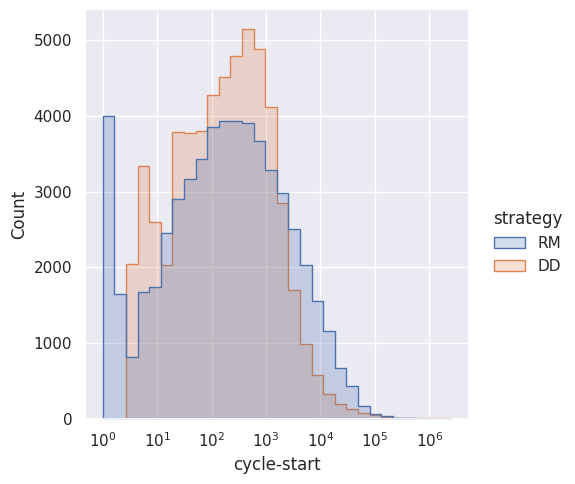

In [39]:
sns.displot(data=df, x='cycle-start', hue='strategy', element='step', log_scale=True, bins=30)

histogram of cycle length for every strategy

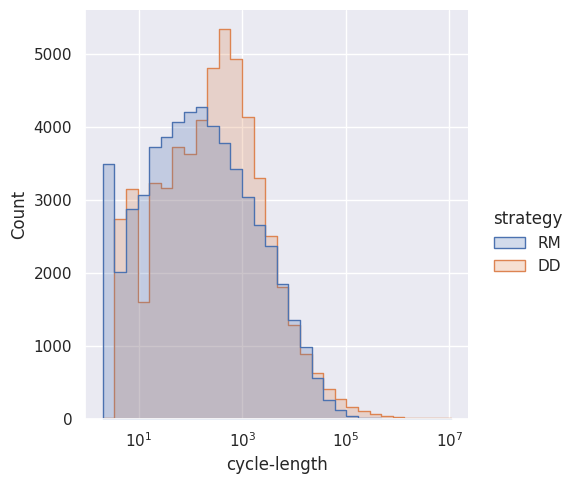

In [40]:
sns.displot(data=df, x='cycle-length', hue='strategy', element='step', log_scale=True, bins=30)

histogram of cycle end for every strategy

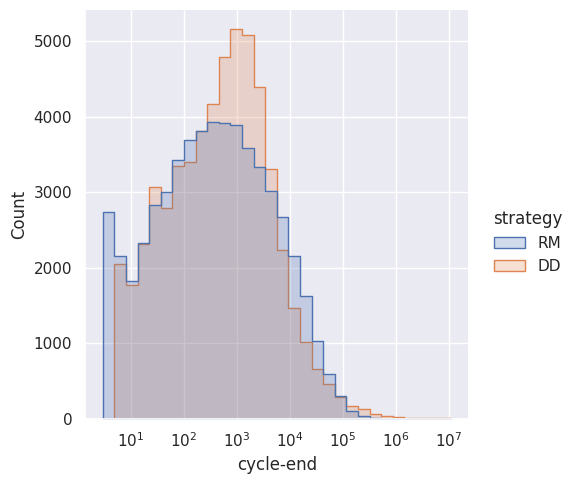

In [41]:
sns.displot(data=df, x='cycle-end', hue='strategy', element='step', log_scale=True, bins=30)

histogram of cycle start for every strategy

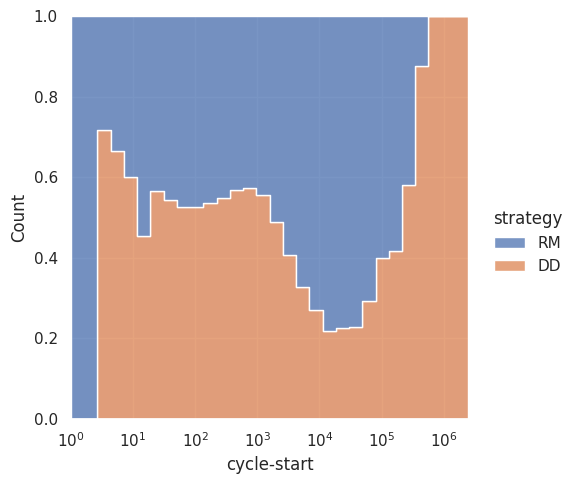

In [42]:
sns.displot(data=df, x='cycle-start', hue='strategy', element='step', multiple='fill', log_scale=True, bins=30)

histogram of cycle length for every strategy

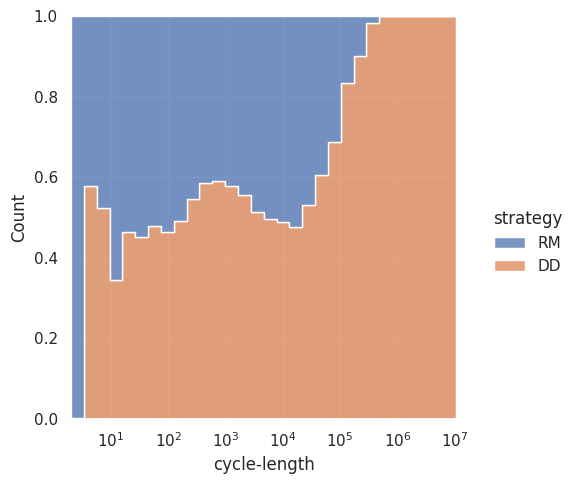

In [43]:
sns.displot(data=df, x='cycle-length', hue='strategy', element='step', multiple='fill', log_scale=True, bins=30)

histogram of cycle end for every strategy

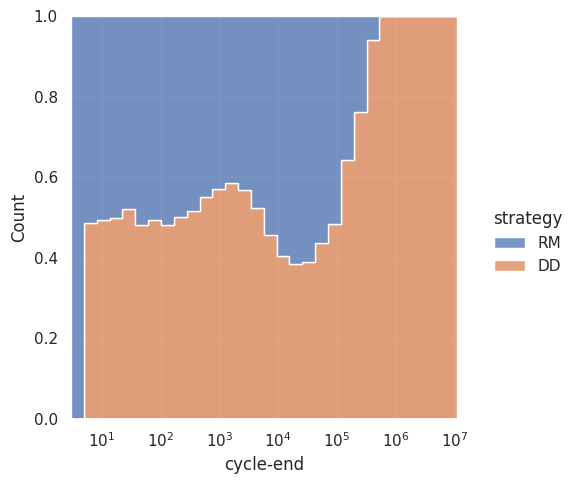

In [44]:
sns.displot(data=df, x='cycle-end', hue='strategy', element='step', multiple='fill', log_scale=True, bins=30)

information about instances with a cycle start in round 1 or 2

In [45]:
df[df['cycle-start'] < 3].groupby('strategy').value_counts('n')

strategy  n
RM        2    4000
          3    1643
dtype: int64

number of instances with very late cycle start and very long cycles

In [46]:
len(df[df['cycle-start'] > 10**6]), len(df[df['cycle-length'] > 10**6])

(4, 29)

statistical information about cycle start, length and end

In [47]:
df.groupby('strategy')[['cycle-start', 'cycle-length', 'cycle-end']].mean()

,cycle-start,cycle-length,cycle-end
strategy,,,
DD,1402.360446,4885.952018,6288.312464
RM,2190.151625,1955.905607,4146.057232


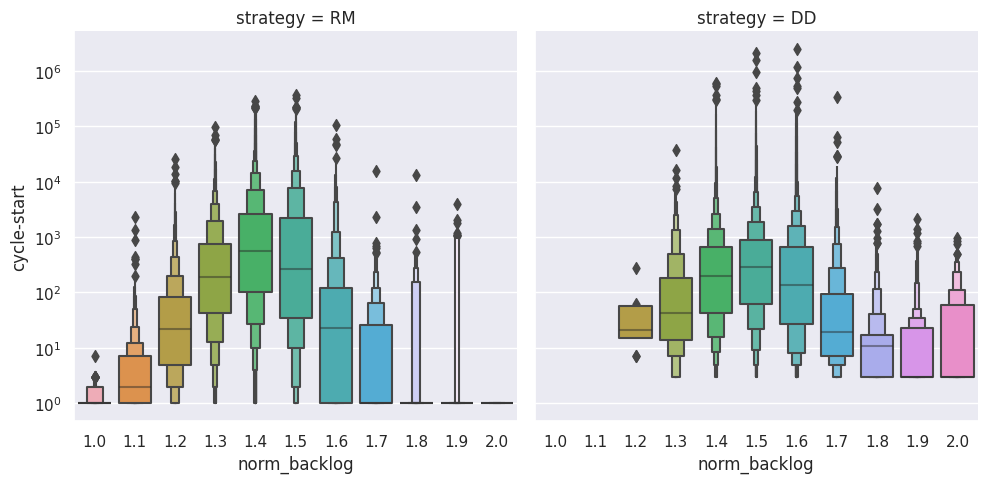

In [48]:
ax = sns.catplot(df.round({'norm_backlog': 1}), x='norm_backlog', y='cycle-start', col='strategy', kind='boxen')
ax.set(yscale='log')

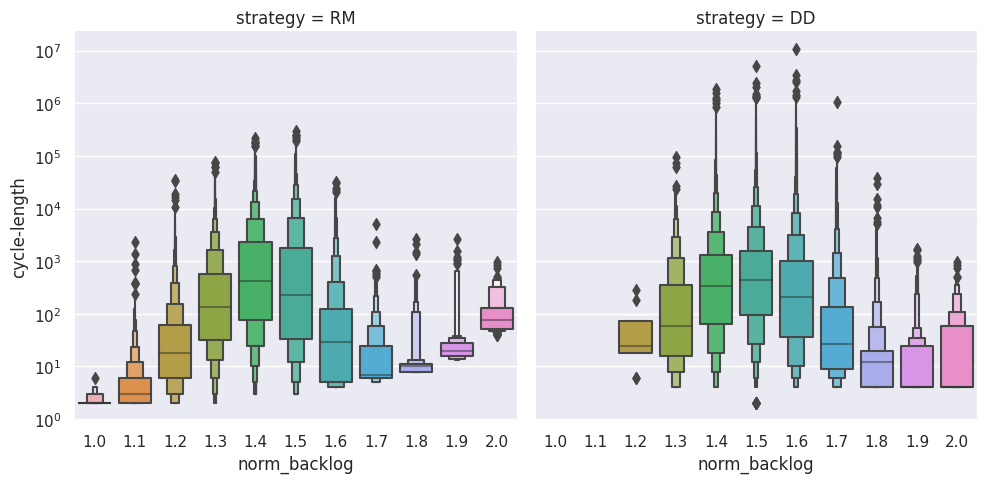

In [49]:
ax = sns.catplot(df.round({'norm_backlog': 1}), x='norm_backlog', y='cycle-length', col='strategy', kind='boxen')
ax.set(yscale='log')

In [50]:
df.round({'norm_backlog': 1}).groupby(['strategy', 'norm_backlog'])[['cycle-start', 'cycle-length']].describe()

cycle-start                                         \
                            count         mean           std  min    25%   
strategy norm_backlog                                                      
DD       1.2                  9.0    56.444444     85.902723  7.0   15.0   
         1.3                578.0   399.814879   1887.427274  3.0   14.0   
         1.4              10630.0  1366.414017  12992.456976  3.0   43.0   
         1.5              26575.0  1605.791759  19196.915345  3.0   62.0   
         1.6              13240.0  1495.044562  26141.099077  3.0   27.0   
         1.7               3007.0   406.271034   6438.790256  3.0    7.0   
         1.8                981.0    47.838940    290.779994  3.0    3.0   
         1.9                670.0    32.044776    129.280524  3.0    3.0   
         2.0                310.0    55.612903    120.443135  3.0    3.0   
RM       1.0                452.0     1.168142      0.487587  1.0    1.0   
         1.1               1825.0    10.587945     69.919597  1.0    1.0   
         1.2               5947.0   147.622162    681.684507  1.0    5.0   
         1.3              18881.0  1063.474922   3149.559506  1.0   42.0   
         1.4              20936.0  3617.331821  10403.526099  1.0  100.0   
         1.5               5876.0  4284.435671  15620.585333  1.0   35.0   
         1.6               1060.0   654.222642   4535.016428  1.0    1.0   
         1.7                419.0    73.221957    759.980912  1.0    1.0   
         1.8                285.0    87.438596    815.244278  1.0    1.0   
         1.9                217.0    65.806452    362.572253  1.0    1.0   
         2.0                102.0     1.000000      0.000000  1.0    1.0   

                                                 cycle-length               \
                         50%      75%        max        count         mean   
strategy norm_backlog                                                        
DD       1.2            21.0    57.00      279.0          9.0    73.333333   
         1.3            43.0   184.00    36701.0        578.0  1102.704152   
         1.4           199.0   666.75   615740.0      10630.0  4465.486924   
         1.5           284.0   903.00  2144560.0      26575.0  5493.636162   
         1.6           134.0   652.00  2475974.0      13240.0  5694.904381   
         1.7            19.0    93.00   336003.0       3007.0  1295.753575   
         1.8            11.0    17.00     7619.0        981.0   177.383282   
         1.9             3.0    23.00     2135.0        670.0    37.989552   
         2.0             3.0    59.00      961.0        310.0    56.296774   
RM       1.0             1.0     1.00        7.0        452.0     2.203540   
         1.1             2.0     7.00     2299.0       1825.0    11.093151   
         1.2            22.0    84.00    25825.0       5947.0   146.828149   
         1.3           187.0   747.00    95438.0      18881.0   921.376039   
         1.4           563.0  2659.25   280844.0      20936.0  3232.037209   
         1.5           268.0  2205.00   370651.0       5876.0  3913.919333   
         1.6            22.5   119.25   104810.0       1060.0   482.244340   
         1.7             1.0    26.00    15332.0        419.0    49.393795   
         1.8             1.0     1.00    13198.0        285.0    48.722807   
         1.9             1.0     1.00     3950.0        217.0    70.502304   
         2.0             1.0     1.00        1.0        102.0   143.176471   

                                                                               
                                 std   min    25%    50%      75%         max  
strategy norm_backlog                                                          
DD       1.2               95.472509   6.0  18.00   24.0    72.00       282.0  
         1.3             6054.672257   4.0  16.00   60.0   360.00     94500.0  
         1.4            39880.909883   4.0  64.00  336.0  1296.00   1859256.0 

letter-value plot showing the round where a cycle starts depending on the number of cups

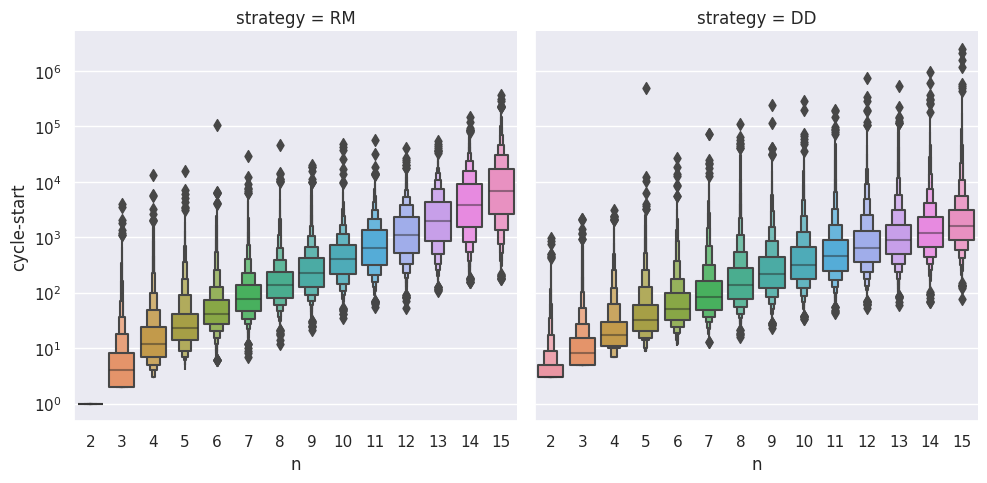

In [51]:
ax = sns.catplot(df, x='n', y='cycle-start', col='strategy', kind='boxen')
ax.set(yscale='log')

letter-value plot showing the cycle length depending on the number of cups

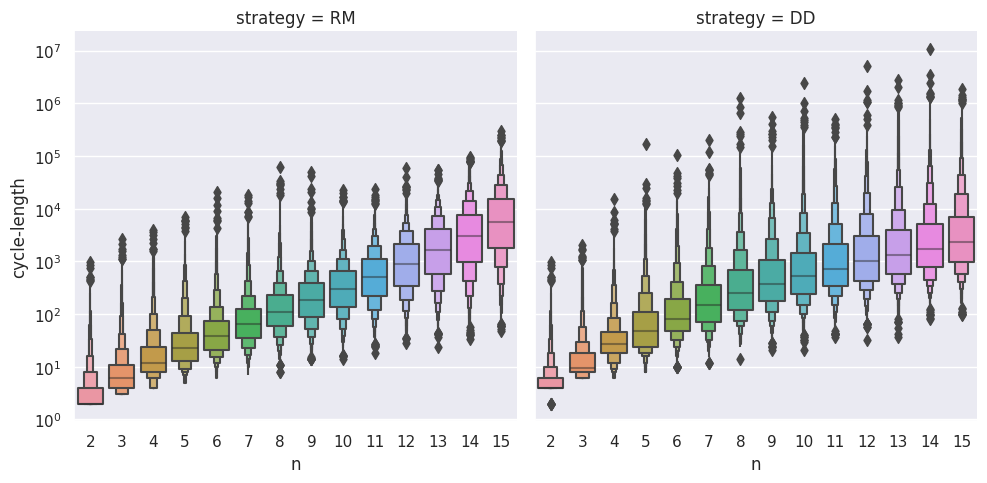

In [52]:
ax = sns.catplot(df, x='n', y='cycle-length', col='strategy', kind='boxen')
ax.set(yscale='log')

letter-value plot showing the cycle end depending on the number of cups

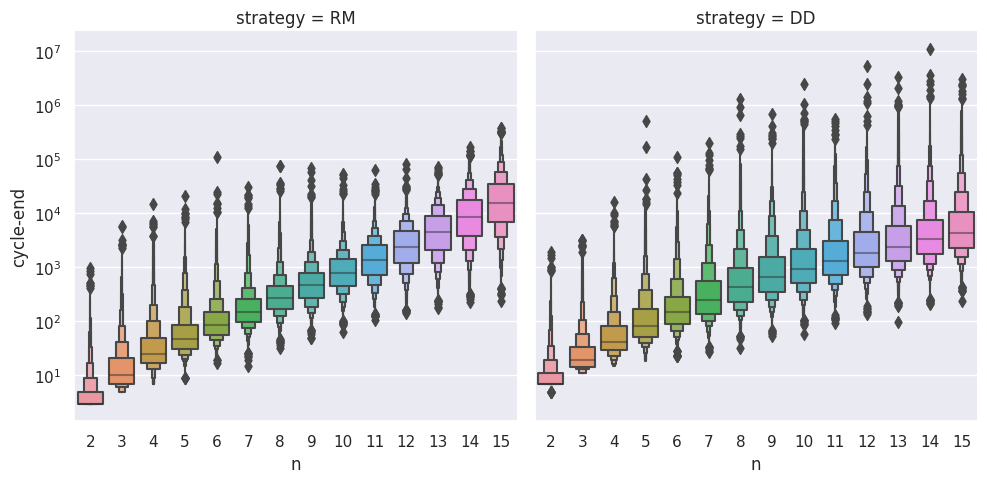

In [53]:
ax = sns.catplot(df, x='n', y='cycle-end', col='strategy', kind='boxen')
ax.set(yscale='log')